The point of this notebook is to find a *global* shift within the time series to ensure that the data is co-registered should there be sub-pixel shifts.

In [14]:
import rasterio
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from itertools import starmap
from skimage.registration import phase_cross_correlation
import scipy.ndimage as nd
import shutil
from rscube import interpolate_nn, bilinear_interpolate

In [2]:
DATA_DIR_NAME = f'data/asf_data_reprojected'
DATA_DIR = Path(DATA_DIR_NAME)
DATA_DIR.exists()

True

In [3]:
OUT_DIR = Path(str(DATA_DIR).replace('_reprojected', '_coregistered'))
OUT_DIR.mkdir(exist_ok=True, parents=True)
OUT_DIR.exists()

True

In [4]:
hh_paths = sorted(list(DATA_DIR.glob('*/*hh*.tif')))
hv_paths = sorted(list(DATA_DIR.glob('*/*hv*.tif')))
hv_paths

[PosixPath('data/asf_data_reprojected/hv/ALOS1_RTC_hv_20070616.tif'),
 PosixPath('data/asf_data_reprojected/hv/ALOS1_RTC_hv_20070801.tif'),
 PosixPath('data/asf_data_reprojected/hv/ALOS1_RTC_hv_20080918.tif'),
 PosixPath('data/asf_data_reprojected/hv/ALOS1_RTC_hv_20090621.tif'),
 PosixPath('data/asf_data_reprojected/hv/ALOS1_RTC_hv_20090806.tif'),
 PosixPath('data/asf_data_reprojected/hv/ALOS1_RTC_hv_20100624.tif'),
 PosixPath('data/asf_data_reprojected/hv/ALOS1_RTC_hv_20100809.tif'),
 PosixPath('data/asf_data_reprojected/hv/ALOS1_RTC_hv_20100924.tif')]

In [5]:
with rasterio.open(hv_paths[0]) as ds:
    profile = ds.profile

In [6]:
def read_arr(path):
    with rasterio.open(path) as ds:
        arr = ds.read(1)
    return arr
hv_ts = list(map(read_arr, hv_paths))
hh_ts = list(map(read_arr, hh_paths))

In [7]:
def f(img):
    img_ = img[-1000: , -1000:]
    img_ = interpolate_nn(img_)
    return img_
hv_ts_nn_fill = list(map(f, tqdm(hv_ts)))

100%|██████████| 8/8 [00:00<00:00, 12.53it/s]


In [8]:
reference_img = hv_ts_nn_fill[0]

In [9]:
def get_shift(img):
    shift, _, _ = phase_cross_correlation(reference_img, img,
                                          upsample_factor=100)
    return shift

In [10]:
shifts = list(map(get_shift, tqdm(hv_ts_nn_fill)))
shifts, len(shifts)

100%|██████████| 8/8 [00:00<00:00, 13.41it/s]


([array([0., 0.]),
  array([-0.43, -0.38]),
  array([-0.38, -0.39]),
  array([-0.38, -0.37]),
  array([-0.39, -0.39]),
  array([-0.01, -0.03]),
  array([-0.01,  0.01]),
  array([-0.04, -0.01])],
 8)

In [11]:
resample = True
mask = np.isnan(hv_ts[0])

In [43]:
def resample(img, shift):
    indices_y, indices_x = np.indices(img.shape)
    y_shift, x_shift = shift
    if resample:
        img_r = interpolate_nn(img)
        #img_resampled = bilinear_interpolate(img_, 
        #                                 indices_x - x_shift, 
        #                                 indices_y - y_shift,
        #                                 nan_boundaries=False)
        img_r = nd.shift(img_r, 
                         (y_shift, x_shift), 
                         mode='constant',
                         cval=np.nan
                        )
        img_r[mask] = np.nan
    else:
        img_r = img
    #img_resampled = np.clip(img_resampled, 0.00001, .5)
    return img_r

In [44]:
hh_ts_coreg = list(starmap(resample, tqdm(zip(hh_ts, shifts), total=len(hh_ts))))
hv_ts_coreg = list(starmap(resample, tqdm(zip(hv_ts, shifts), total=len(hv_ts))))

100%|██████████| 8/8 [00:08<00:00,  1.10s/it]


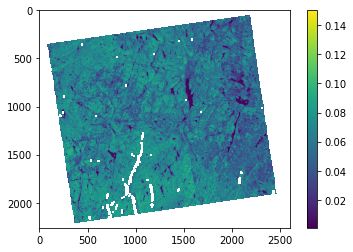

In [45]:
plt.imshow(hv_ts_coreg[0], vmax=.15)
plt.colorbar()

 # Write

In [46]:
def write_one(img, dest_path):
    with rasterio.open(dest_path, 'w', **profile) as ds:
        ds.write(img.astype(np.float32), 1)
    return dest_path

In [47]:
(OUT_DIR/'hh').mkdir(exist_ok=True, parents=True)
(OUT_DIR/'hv').mkdir(exist_ok=True, parents=True)

In [48]:
hh_dest_paths = hh_paths.copy()
hv_dest_paths = hv_paths.copy()
hh_dest_paths = [OUT_DIR/'hh'/path.name for path in hh_dest_paths]
hv_dest_paths = [OUT_DIR/'hv'/path.name for path in hv_dest_paths]
hh_dest_paths

[PosixPath('data/asf_data_coregistered/hh/ALOS1_RTC_hh_20070616.tif'),
 PosixPath('data/asf_data_coregistered/hh/ALOS1_RTC_hh_20070801.tif'),
 PosixPath('data/asf_data_coregistered/hh/ALOS1_RTC_hh_20080918.tif'),
 PosixPath('data/asf_data_coregistered/hh/ALOS1_RTC_hh_20090621.tif'),
 PosixPath('data/asf_data_coregistered/hh/ALOS1_RTC_hh_20090806.tif'),
 PosixPath('data/asf_data_coregistered/hh/ALOS1_RTC_hh_20100624.tif'),
 PosixPath('data/asf_data_coregistered/hh/ALOS1_RTC_hh_20100809.tif'),
 PosixPath('data/asf_data_coregistered/hh/ALOS1_RTC_hh_20100924.tif')]

In [49]:
len(hh_ts_coreg)

8

In [50]:
list(starmap(write_one, zip(tqdm(hh_ts_coreg), (hh_dest_paths))))
list(starmap(write_one, zip(tqdm(hv_ts_coreg), (hv_dest_paths))))

100%|██████████| 8/8 [00:01<00:00,  6.97it/s]


[PosixPath('data/asf_data_coregistered/hv/ALOS1_RTC_hv_20070616.tif'),
 PosixPath('data/asf_data_coregistered/hv/ALOS1_RTC_hv_20070801.tif'),
 PosixPath('data/asf_data_coregistered/hv/ALOS1_RTC_hv_20080918.tif'),
 PosixPath('data/asf_data_coregistered/hv/ALOS1_RTC_hv_20090621.tif'),
 PosixPath('data/asf_data_coregistered/hv/ALOS1_RTC_hv_20090806.tif'),
 PosixPath('data/asf_data_coregistered/hv/ALOS1_RTC_hv_20100624.tif'),
 PosixPath('data/asf_data_coregistered/hv/ALOS1_RTC_hv_20100809.tif'),
 PosixPath('data/asf_data_coregistered/hv/ALOS1_RTC_hv_20100924.tif')]

# Copy DEM

In [51]:
dem_path = DATA_DIR/'dem.tif'

shutil.copy(dem_path, OUT_DIR/'dem.tif')

PosixPath('data/asf_data_coregistered/dem.tif')